In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from model_builder_cs3 import build_cqm
from dotenv import load_dotenv, find_dotenv
import os
import numpy as np

In [2]:
from math import radians as DegToRad, cos, radians, sin, sqrt

In [3]:
from dimod import ConstrainedQuadraticModel, Integer, Binary, quicksum, QuadraticModel, BinaryQuadraticModel
from dwave.system import LeapHybridCQMSampler

In [4]:
# Load Environmental Variables
load_dotenv(find_dotenv())
token = os.environ['DWAVE_API_KEY'] 

In [5]:
import requests
import yaml

# URL of the online YAML file
yaml_url = 'https://raw.githubusercontent.com/IEAWindTask37/iea37-wflo-casestudies/master/cs3-4/iea37-windrose-cs3.yaml'
# Fetch the YAML content from the URL
response = requests.get(yaml_url)
yaml_data = response.text

# Load YAML data
data = yaml.safe_load(yaml_data)

# Extract the desired information
wind_direction_bins = data['definitions']['wind_inflow']['properties']['direction']['bins']
wind_direction_probability = data['definitions']['wind_inflow']['properties']['direction']['frequency']
wind_speed_bins = data['definitions']['wind_inflow']['properties']['speed']['bins']
wind_speed_probability = data['definitions']['wind_inflow']['properties']['speed']['frequency']

In [6]:
len(wind_speed_probability)

20

In [7]:
# URL of the online YAML file
yaml_url = 'https://raw.githubusercontent.com/IEAWindTask37/iea37-wflo-casestudies/master/cs3-4/iea37-10mw.yaml'

# Fetch the YAML content from the URL
response = requests.get(yaml_url)
yaml_data = response.text

# Load YAML data
data = yaml.safe_load(yaml_data)

# Extract the wind_turbine_lookup default value
wind_turbine_power = data['definitions']['wind_turbine']['rated_power']['maximum']/1e6

# Print the extracted default value
print("wind_turbine_power:", wind_turbine_power)


wind_turbine_power: 10.0


In [8]:
#Extract the "Rotor Radius"
rotor_radius = data['definitions']['rotor']['radius']['default']
print("rotor_radius:", rotor_radius)

# Extract the "Cut-In Wind Speed"
cut_in_wind_speed = data['definitions']['operating_mode']['cut_in_wind_speed']['default']

# Print the extracted "Cut-In Wind Speed"
print("Cut-In Wind Speed:", cut_in_wind_speed)

# Extract the "Cut-Out Wind Speed"
cut_out_wind_speed = data['definitions']['operating_mode']['cut_out_wind_speed']['default']

# Print the extracted "Cut-Out Wind Speed"
print("Cut-Out Wind Speed:", cut_out_wind_speed)

# Extract the "Rated Wind Speed"
rated_wind_speed = data['definitions']['operating_mode']['rated_wind_speed']['default']

# Print the extracted "Rated Wind Speed"
print("Rated Wind Speed:", rated_wind_speed)

# Extract the "Hub Height"
hub_height = data['definitions']['hub']['height']['default']

# Print the extracted "Hub Height"
print("Hub Height:", hub_height)

rotor_radius: 99.0
Cut-In Wind Speed: 4.0
Cut-Out Wind Speed: 25.0
Rated Wind Speed: 11.0
Hub Height: 119.0


In [9]:
def WindFrame(turb_coords, wind_dir_deg):
    """Convert map coordinates to downwind/crosswind coordinates."""

    # Convert from meteorological polar system (CW, 0 deg.=N)
    # to standard polar system (CCW, 0 deg.=W)
    # Shift so North comes "along" x-axis, from left to right.
    wind_dir_deg = 270. - wind_dir_deg
    # Convert inflow wind direction from degrees to radians
    wind_dir_rad = DegToRad(wind_dir_deg)

    # Constants to use below
    cos_dir = np.cos(-wind_dir_rad)
    sin_dir = np.sin(-wind_dir_rad)
    # Convert to downwind(x) & crosswind(y) coordinates
    frame_coords = np.recarray(len(turb_coords), coordinate)
    frame_coords.x = (turb_coords[:, 0] * cos_dir) - \
        (turb_coords[:, 1] * sin_dir)
    frame_coords.y = (turb_coords[:, 0] * sin_dir) + \
        (turb_coords[:, 1] * cos_dir)

    return frame_coords

In [10]:
def GaussianWake(frame_coords, turb_diam):
    """Return each turbine's total loss due to wake from upstream turbines"""
    # Equations and values explained in <iea37-wakemodel.pdf>
    num_turb = len(frame_coords)

    # Constant thrust coefficient
    CT = 4.0*1./3.*(1.0-1./3.)
    # Constant, relating to a turbulence intensity of 0.075
    k = 0.0324555
    # Array holding the wake deficit seen at each turbine
    loss = np.zeros(num_turb)

    for i in range(num_turb):            # Looking at each turb (Primary)
        loss_array = np.zeros(num_turb)  # Calculate the loss from all others
        for j in range(num_turb):        # Looking at all other turbs (Target)
            x = frame_coords.x[i] - frame_coords.x[j]   # Calculate the x-dist
            y = frame_coords.y[i] - frame_coords.y[j]   # And the y-offset
            if x > 0.:                   # If Primary is downwind of the Target
                sigma = k*x + turb_diam/np.sqrt(8.)  # Calculate the wake loss
                # Simplified Bastankhah Gaussian wake model
                exponent = -0.5 * (y/sigma)**2
                radical = 1. - CT/(8.*sigma**2 / turb_diam**2)
                loss_array[j] = (1.-np.sqrt(radical)) * np.exp(exponent)
            # Note that if the Target is upstream, loss is defaulted to zero
        # Total wake losses from all upstream turbs, using sqrt of sum of sqrs
        loss[i] = np.sqrt(np.sum(loss_array**2))

    return loss

In [11]:
def DirPower(frame_coords, dir_loss, wind_speed,
             turb_ci, turb_co, rated_ws, rated_pwr):
    """Return the power produced by each turbine."""
    num_turb = frame_coords.shape[0]

    # Effective windspeed is freestream multiplied by wake deficits
    wind_speed_eff = wind_speed*(1.-dir_loss)
    # By default, the turbine's power output is zero
    turb_pwr = np.zeros(num_turb)

    # Check to see if turbine produces power for experienced wind speed
    for n in range(num_turb):
        # If we're between the cut-in and rated wind speeds
        if ((turb_ci <= wind_speed_eff[n])
                and (wind_speed_eff[n] < rated_ws)):
            # Calculate the curve's power
            turb_pwr[n] = rated_pwr * ((wind_speed_eff[n]-turb_ci)
                                       / (rated_ws-turb_ci))**3
        # If we're between the rated and cut-out wind speeds
        elif ((rated_ws <= wind_speed_eff[n])
                and (wind_speed_eff[n] < turb_co)):
            # Produce the rated power
            turb_pwr[n] = rated_pwr

    # Sum the power from all turbines for this direction
    pwrDir = np.sum(turb_pwr)

    return pwrDir

In [12]:
def calcAEPcs3(turb_coords, wind_freq, wind_speeds, wind_speed_probs, wind_dir,
            turb_diam, turb_ci, turb_co, rated_ws, rated_pwr):
    """Calculate the wind farm AEP."""
    num_dir_bins = len(wind_freq)       # Number of bins used for our windrose
    num_speed_bins = len(wind_speeds)   # Number of wind speed bins)

    # Power produced by the wind farm from each wind direction
    pwr_prod_dir = np.zeros(num_dir_bins)
    #  Power produced by the wind farm at a given windspeed
    pwr_prod_ws = np.zeros((num_dir_bins, num_speed_bins))

    # For each directional bin
    for i in range(num_dir_bins):
        # For each wind speed bin
        # Shift coordinate frame of reference to downwind/crosswind
        frame_coords = WindFrame(turb_coords, wind_dir[i])
        # Use the Simplified Bastankhah Gaussian wake model for wake deficits
        dir_loss = GaussianWake(frame_coords, turb_diam)

        for j in range(num_speed_bins):
            # Find the farm's power for the current direction and speed,
            # multiplied by the probability that the speed will occur
            pwr_prod_ws[i][j] = DirPower(frame_coords, dir_loss, wind_speeds[j],
                                        turb_ci, turb_co, rated_ws,
                                        rated_pwr) * wind_speed_probs[i][j]
        pwr_prod_dir[i] = sum(pwr_prod_ws[i]) * wind_freq[i]

    #  Convert power to AEP
    hrs_per_year = 365.*24.
    AEP = hrs_per_year * pwr_prod_dir
    #AEP /= 1.E6  # Convert to MWh

    return AEP

In [ ]:
#! pip install shapely

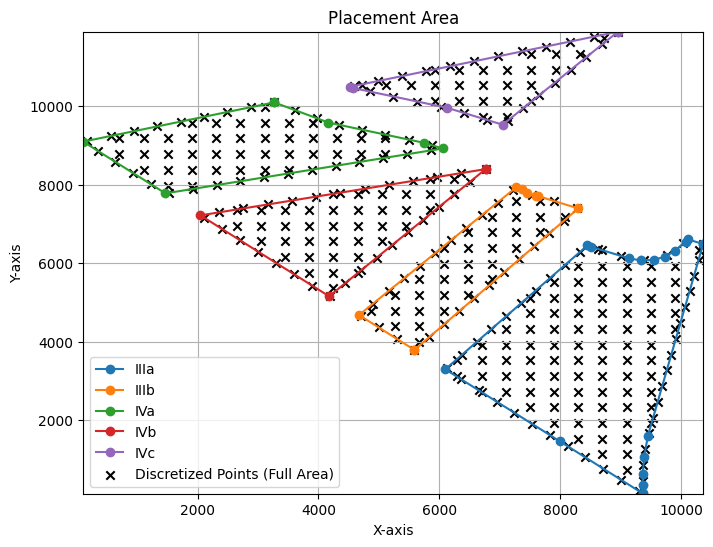

In [13]:
import yaml
import requests
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from shapely.geometry import Polygon, Point

def extract_coordinates_from_url(yaml_url):
    response = requests.get(yaml_url)
    yaml_data = response.text
    data = yaml.safe_load(yaml_data)
    
    # Extract coordinates from all available regions
    all_coordinates = {region: data.get('boundaries', {}).get(region, []) for region in data.get('boundaries', {})}
    
    # Concatenate all coordinates to get the full area
    full_area_coordinates = [coord for coordinates in all_coordinates.values() for coord in coordinates]
    
    # Discretize the full area
    grid_resolution = 400
    discretized_points = discretize_area(all_coordinates, grid_resolution)
    
    # Convert to NumPy array for further manipulation
    np_coordinates = {region: np.array(coordinates) for region, coordinates in all_coordinates.items()}
    
    # Extract X and Y coordinates from Point objects
    potential_nodes = [(point.x, point.y) for point in discretized_points]
    
    return full_area_coordinates, discretized_points, all_coordinates, np_coordinates, potential_nodes

def discretize_area(all_coordinates, grid_resolution, boundary_points_span=400):
    points = []

    for region_coordinates in all_coordinates.values():
        polygon = Polygon(region_coordinates)
        exterior = polygon.exterior

        # Calculate the total length of the exterior boundary
        total_length = exterior.length

        # Calculate the number of points to be generated along the boundary
        num_boundary_points = int(total_length / boundary_points_span)

        # Generate points along the exterior boundary
        for i in np.linspace(0, 1, num_boundary_points, endpoint=False):
            point = exterior.interpolate(i, normalized=True)
            points.append(point)

        # Determine bounding box for points inside the polygon
        min_x, min_y, max_x, max_y = polygon.bounds

        # Define grid resolution for points inside the polygon
        dx = dy = grid_resolution

        # Generate points inside the polygon
        for x in np.arange(min_x, max_x, dx):
            for y in np.arange(min_y, max_y, dy):
                point = Point(x + dx / 2, y + dy / 2)  # Use cell center as a representative point
                if polygon.contains(point):
                    points.append(point)

    return points



def plot_coordinates(ax, coordinates, label, color='blue'):
    x_coordinates, y_coordinates = zip(*coordinates)
    ax.plot(x_coordinates + (x_coordinates[0],), y_coordinates + (y_coordinates[0],), label=label, color=color, marker='o')

def plot_all_regions(yaml_url):
    # Fetch all coordinates
    _, discretized_points, all_coordinates, _, _ = extract_coordinates_from_url(yaml_url)

    # Get the overall bounding box for all regions
    all_x_coordinates = [coord[0] for coordinates in all_coordinates.values() for coord in coordinates]
    all_y_coordinates = [coord[1] for coordinates in all_coordinates.values() for coord in coordinates]

    min_x, max_x = min(all_x_coordinates), max(all_x_coordinates)
    min_y, max_y = min(all_y_coordinates), max(all_y_coordinates)

    # Plotting
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title('Placement Area')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.grid(True)

    region_colors = iter(plt.cm.tab10.colors)

    for region_of_interest, coordinates in all_coordinates.items():
        color = next(region_colors)
        plot_coordinates(ax, coordinates, region_of_interest, color=color)

    # Plot the discretized points for the full area
    discretized_x, discretized_y = zip(*[(point.x, point.y) for point in discretized_points])
    ax.scatter(discretized_x, discretized_y, color='black', marker='x', label='Discretized Points (Full Area)')

    # Set axis limits based on the overall bounding box
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)

    # Add legend
    ax.legend()
    plt.show()

    return discretized_points  # Return discretized_points outside the function

# URL of the online YAML file
yaml_url = 'https://raw.githubusercontent.com/IEAWindTask37/iea37-wflo-casestudies/master/cs3-4/iea37-boundary-cs4.yaml'

# Plot boundaries for all regions in the same plot with different colors
discretized_points = plot_all_regions(yaml_url)

# Now discretized_points is accessible outside the function


In [14]:
len(discretized_points)

377

In [15]:
# Extract X and Y coordinates from Point objects
potential_nodes = [(int(point.x), int(point.y)) for point in discretized_points]
len(potential_nodes)

377

In [ ]:
potential_nodes

In [16]:
def solve(cqm, time_limit=5):

  """
    Solve the Constrained Quadratic Model (CQM) using the LeapHybridCQMSampler.

    Args:
        cqm (ConstrainedQuadraticModel): The Constrained Quadratic Model to solve.
        time_limit (int): Time limit in seconds for the solver.

    Returns:
        sampleset (SampleSet): The resulting sampleset from the solver.
    """

  sampler = LeapHybridCQMSampler(token=token)
  print("Submitting CQM to solver {}.".format(sampler.solver.name))
  sampleset = sampler.sample_cqm(cqm, label='WFLOP_CS3', time_limit=time_limit)
  return sampleset

In [17]:
def parse_solution(sampleset):

  """
    Parse the solution from the sampleset obtained from the solver.

    Args:
        sampleset (SampleSet): The sampleset obtained from the solver.

    Returns:
        energy (float): The energy of the best solution.
        non_zero_values (dict): Dictionary of non-zero values in the best solution.
    Raises:
        ValueError: If no feasible solution is found in the sampleset.
    """

  feasible_sampleset = sampleset.filter(lambda row: row.is_feasible)
  if not len(feasible_sampleset):
    raise ValueError("No feasible solution found")
  
  solution = feasible_sampleset.first.sample
  non_zero_values = {key: int(value) for key, value in solution.items() if value != 0}
  energy = feasible_sampleset.first.energy
  
  return energy, non_zero_values

In [18]:
def print_solution(solution):
    """
    Print the selected wind towers and their corresponding Cartesian coordinates.

    Parameters:
    - solution (dict): A dictionary representing the selected wind towers and their binary values.

    Returns:
    - None
    """

    selected_towers = []

    for var_name, value in solution.items():
        if value == 1:
            # Parse the variable name to extract angle and radius
            parts = var_name.split('_')
            if len(parts) == 2:  # Check if there are two parts in the variable name
                x = float(parts[0])
                y = float(parts[1])
                selected_towers.append((x, y))


    # Display the result with sequential numbers and the desired format
    for index, cartesian in enumerate(selected_towers, start=1):
        print(f"Turbine {index} -> {cartesian}")

    # Create a scatter plot for Cartesian coordinates
    plt.figure(figsize=(8, 8))
    
    xc, yc = zip(*selected_towers)
    plt.scatter(xc, yc, marker='o', c='b')

    # Add labels to Cartesian plot
    for i, (x, y) in enumerate(zip(xc, yc), start=1):
        plt.text(x, y, str(i), color='red', fontsize=15)

    # Customize the Cartesian plot
    plt.title("Cartesian Coordinates")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.grid(True)

    # Show both plots
    plt.tight_layout()
    plt.show()

def get_solution_coordinates(solution):
    """
    Get the Cartesian coordinates of the selected wind towers based on the given solution.

    Parameters:
    - solution (dict): A dictionary representing the selected wind towers and their binary values.

    Returns:
    - list: A list containing the Cartesian coordinates of each selected wind tower.
    """

    selected_towers = []

    for var_name, value in solution.items():
        if value == 1:
            # Parse the variable name to extract angle and radius
            parts = var_name.split('_')
            if len(parts) == 2:  # Check if there are two parts in the variable name
                angle = float(parts[0])
                radius = float(parts[1])
                selected_towers.append((angle, radius))

    

    return np.asarray(selected_towers)


In [19]:
# Define the number of turbines
n_turbines = 81

# Define the yearly operative working hours of the farm
yearly_working_hours = 8760

# Calculate the diameter from the radius
diameter = 2 * rotor_radius

# Define the minimum distance as 2 times the rotor diameter
minimum_distance = 2 * diameter

# Print the minimum distance
print("Minimum Distance:", minimum_distance)

Minimum Distance: 396.0


In [20]:
wind_tower_labels = [f'{x}_{y}' for x, y in potential_nodes]

In [21]:
len(wind_tower_labels)

377

In [ ]:
wind_tower_labels

In [22]:
coordinate = np.dtype([('x', 'f8'), ('y', 'f8')])
#  Initialize CQM
cqm = build_cqm(wind_tower_labels, coordinate, wind_direction_bins, wind_speed_bins,
              rated_wind_speed, diameter, cut_in_wind_speed, cut_out_wind_speed,
              wind_turbine_power, wind_direction_probability, wind_speed_probability,
              DirPower, n_turbines, potential_nodes, minimum_distance)

In [24]:
cqm.variables

Variables(['10363_6490', '10288_6087', '10213_5685', '10138_5283', '10062_4880', '9987_4478', '9912_4076', '9837_3673', '9761_3271', '9686_2869', '9611_2466', '9536_2064', '9460_1662', '9409_1256', '9376_848', '9362_439', '9299_197', '9004_482', '8710_766', '8416_1051', '8122_1336', '7828_1621', '7534_1906', '7240_2190', '6946_2475', '6652_2760', '6358_3045', '6126_3334', '6370_3663', '6615_3991', '6859_4319', '7104_4648', '7348_4976', '7593_5304', '7837_5632', '8082_5961', '8326_6289', '8630_6363', '9000_6189', '9388_6076', '9769_6199', '10037_6506', '6298_3126', '6298_3526', '6698_2726', '6698_3126', '6698_3526', '6698_3926', '7098_2726', '7098_3126', '7098_3526', '7098_3926', '7098_4326', '7498_2326', '7498_2726', '7498_3126', '7498_3526', '7498_3926', '7498_4326', '7498_4726', '7498_5126', '7898_1926', '7898_2326', '7898_2726', '7898_3126', '7898_3526', '7898_3926', '7898_4326', '7898_4726', '7898_5126', '7898_5526', '8298_1526', '8298_1926', '8298_2326', '8298_2726', '8298_3126', 

Submitting CQM to solver hybrid_constrained_quadratic_model_version1.
Turbine 1 -> (1107.0, 8781.0)
Turbine 2 -> (1507.0, 8781.0)
Turbine 3 -> (1907.0, 8781.0)
Turbine 4 -> (1907.0, 9581.0)
Turbine 5 -> (2307.0, 8781.0)
Turbine 6 -> (2307.0, 9581.0)
Turbine 7 -> (2647.0, 6958.0)
Turbine 8 -> (2707.0, 8781.0)
Turbine 9 -> (2707.0, 9581.0)
Turbine 10 -> (3047.0, 6958.0)
Turbine 11 -> (3107.0, 8781.0)
Turbine 12 -> (3107.0, 9581.0)
Turbine 13 -> (3447.0, 6158.0)
Turbine 14 -> (3447.0, 6958.0)
Turbine 15 -> (3507.0, 8781.0)
Turbine 16 -> (3507.0, 9581.0)
Turbine 17 -> (3847.0, 6958.0)
Turbine 18 -> (3907.0, 9581.0)
Turbine 19 -> (4188.0, 5173.0)
Turbine 20 -> (4247.0, 6958.0)
Turbine 21 -> (4247.0, 7758.0)
Turbine 22 -> (4647.0, 6958.0)
Turbine 23 -> (4647.0, 7758.0)
Turbine 24 -> (4961.0, 6141.0)
Turbine 25 -> (5047.0, 6958.0)
Turbine 26 -> (5047.0, 7758.0)
Turbine 27 -> (5447.0, 7758.0)
Turbine 28 -> (5674.0, 5937.0)
Turbine 29 -> (5847.0, 7758.0)
Turbine 30 -> (5924.0, 10531.0)
Turbine 

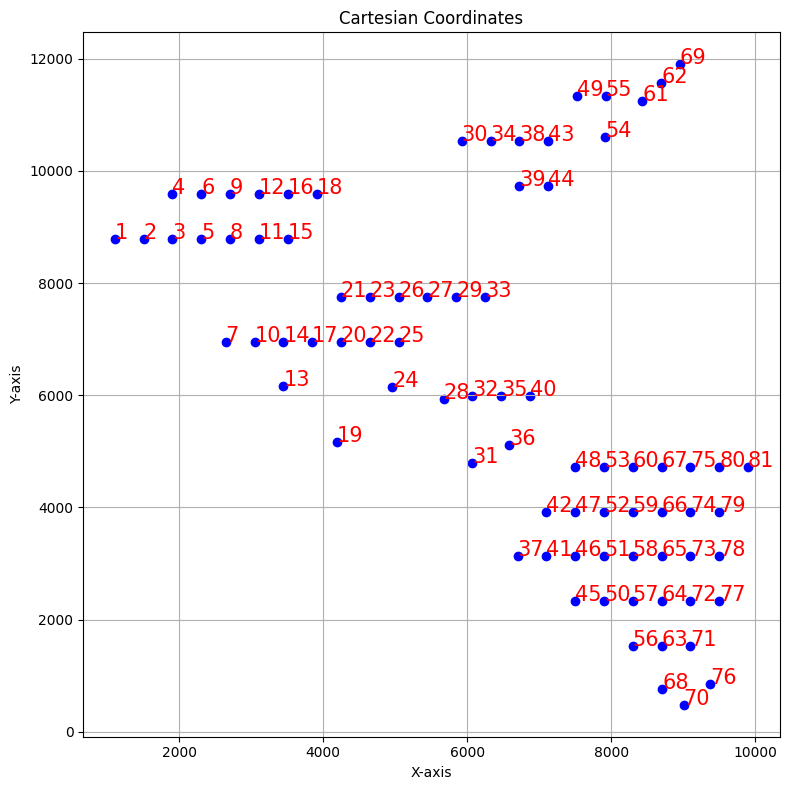

In [25]:
#  Instantiate the sampler
sampleset = solve(cqm, time_limit=100)

# Parse solution
energy, solution = parse_solution(sampleset)

#  Print solution in a human readable diagram
print_solution(solution)

In [ ]:
solution

Turbine 1 -> [1107.0 8781.0]
Turbine 2 -> [1507.0 8781.0]
Turbine 3 -> [1907.0 8781.0]
Turbine 4 -> [1907.0 9581.0]
Turbine 5 -> [2307.0 8781.0]
Turbine 6 -> [2307.0 9581.0]
Turbine 7 -> [2647.0 6958.0]
Turbine 8 -> [2707.0 8781.0]
Turbine 9 -> [2707.0 9581.0]
Turbine 10 -> [3047.0 6958.0]
Turbine 11 -> [3107.0 8781.0]
Turbine 12 -> [3107.0 9581.0]
Turbine 13 -> [3447.0 6158.0]
Turbine 14 -> [3447.0 6958.0]
Turbine 15 -> [3507.0 8781.0]
Turbine 16 -> [3507.0 9581.0]
Turbine 17 -> [3847.0 6958.0]
Turbine 18 -> [3907.0 9581.0]
Turbine 19 -> [4188.0 5173.0]
Turbine 20 -> [4247.0 6958.0]
Turbine 21 -> [4247.0 7758.0]
Turbine 22 -> [4647.0 6958.0]
Turbine 23 -> [4647.0 7758.0]
Turbine 24 -> [4961.0 6141.0]
Turbine 25 -> [5047.0 6958.0]
Turbine 26 -> [5047.0 7758.0]
Turbine 27 -> [5447.0 7758.0]
Turbine 28 -> [5674.0 5937.0]
Turbine 29 -> [5847.0 7758.0]
Turbine 30 -> [5924.0 10531.0]
Turbine 31 -> [6070.0 4791.0]
Turbine 32 -> [6070.0 5991.0]
Turbine 33 -> [6247.0 7758.0]
Turbine 34 -> [632

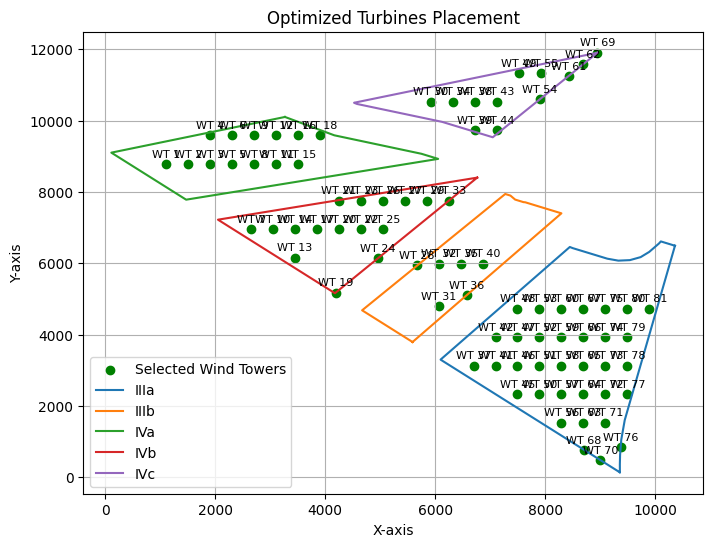

In [27]:
def plot_solution(solution, coordinates):
    """
    Visualize the selected wind towers and the boundaries.

    Parameters:
    - solution (dict): A dictionary representing the selected wind towers and their binary values.
    - coordinates (dict): Coordinates of the boundaries, with keys representing region names.

    Returns:
    - None
    """

    # Extract selected tower coordinates
    selected_towers = get_solution_coordinates(solution)

    # Plotting
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title('Optimized Turbines Placement')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.grid(True)

    # Plot selected wind towers
    selected_x, selected_y = zip(*selected_towers)
    ax.scatter(selected_x, selected_y, color='green', marker='o', label='Selected Wind Towers')

    # Plot boundaries with color-coded legend
    for region_name, region_coordinates in coordinates.items():
        x_coordinates, y_coordinates = zip(*region_coordinates)
        ax.plot(x_coordinates + (x_coordinates[0],), y_coordinates + (y_coordinates[0],), label=f'{region_name}')

    # Print coordinates of selected wind towers and couple with notes on the graph
    for i, (x, y) in enumerate(selected_towers, start=1):
        ax.annotate(f'WT {i}', (x, y), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8, color='black')
        print(f'Turbine {i} -> [{x} {y}]')

    # Set legend outside the plot and adjust position
    #ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.legend(loc='lower left')
    plt.show()

_, _, all_coordinates, _, _ = extract_coordinates_from_url(yaml_url)

# Call the plot_solution function
plot_solution(solution, all_coordinates)


In [28]:
cartesian_coords = get_solution_coordinates(solution)

In [29]:
#-- Calculate the AEP from ripped values --#
AEP = calcAEPcs3(cartesian_coords, wind_direction_probability, wind_speed_bins, wind_speed_probability, wind_direction_bins,
            diameter, cut_in_wind_speed, cut_out_wind_speed, rated_wind_speed, wind_turbine_power)
# Print AEP summed for all directions
print(np.around(AEP, decimals=5))
# Print AEP summed for all directions
print(f"\nTotal Wind Farm AEP = {int(np.round(np.sum(AEP))):,} MWh")

[ 51431.37632  47888.55165  43633.29479  43138.39957  53256.1585
  38962.84052 140149.6871  161881.37911 130754.84081 132912.97829
 141994.30179 211459.16506 230662.42173 231182.76116 204451.89259
  90295.12934 201761.099   206276.825   169602.01343 111429.78734]

Total Wind Farm AEP = 2,643,125 MWh


In [31]:
import numpy as np

data = [
    [10363.7833, 6490.2719], [9894.9437, 6316.9180], [8450.2895, 6455.3421],
    [9022.1294, 6114.0806], [9593.9692, 5772.8191], [10165.8090, 5431.5577],
    [7979.8825, 5823.7831], [8642.5333, 5340.1365], [9305.1840, 4856.4899],
    [9967.8348, 4372.8434], [7509.4754, 5192.2241], [8074.5717, 4722.7003],
    [8639.6679, 4253.1766], [9204.7642, 3783.6529], [9769.8606, 3314.1291],
    [7039.0683, 4560.6651], [7672.2728, 3984.3525], [8305.4773, 3408.0400],
    [8938.6818, 2831.7274], [9571.8863, 2255.4149], [6568.6612, 3929.1061],
    [7277.1539, 3244.9222], [7985.6467, 2560.7382], [8694.1395, 1876.5542],
    [9402.6323, 1192.3703], [6098.2541, 3297.5471], [6750.8566, 2665.4498],
    [7403.4592, 2033.3525], [8056.0622, 1401.2557], [8708.6700, 769.1637],
    [9361.2778, 137.0718], [8297.1401, 7398.8969], [7057.9009, 7669.1317],
    [7755.3966, 6677.3823], [6537.0543, 7017.0094], [7213.6530, 5955.8679],
    [6016.2077, 6364.8870], [6671.9094, 5234.3534], [5495.3611, 5712.7647],
    [6130.1658, 4512.8390], [4974.5145, 5060.6424], [5588.4223, 3791.3245],
    [3267.0701, 10100.6305], [4145.9677, 9596.9976], [5107.1349, 9278.5659],
    [6054.6902, 8925.3415], [2213.8627, 9767.0876], [2951.0233, 9359.4397],
    [3743.0302, 8951.7917], [4525.9626, 8544.1437], [1160.6553, 9433.5446],
    [1756.0788, 8951.7917], [2378.9255, 8586.4789], [2997.2350, 8162.9460],
    [107.4479, 9100.0017], [561.1344, 8660.5839], [1014.8209, 8221.1661],
    [1468.5074, 7781.7483], [6764.9216, 8399.6839], [6034.3987, 7957.6709],
    [4878.0741, 7928.0749], [5729.6775, 7103.2410], [3934.6503, 7692.2704],
    [4573.3529, 7073.6450], [5212.0555, 6455.0196], [2991.2265, 7456.4659],
    [3842.8300, 6631.6320], [4694.4335, 5806.7981], [2047.8027, 7220.6614],
    [2757.4723, 6533.2998], [3467.1419, 5845.9382], [4176.8115, 5158.5767],
    [8953.7052, 11901.4945], [7846.3157, 11550.7937], [6738.9262, 11200.0929],
    [5631.5367, 10849.3921], [4524.1472, 10498.6913], [8001.0152, 10716.4728],
    [6893.6257, 10365.7720], [5806.1713, 10066.8889], [7048.3252, 9531.4511]
]

cartesian_coords_test = np.array(data)


In [32]:
#-- Calculate the AEP from ripped values --#
AEP = calcAEPcs3(cartesian_coords_test, wind_direction_probability, wind_speed_bins, wind_speed_probability, wind_direction_bins,
            diameter, cut_in_wind_speed, cut_out_wind_speed, rated_wind_speed, wind_turbine_power)
# Print AEP summed for all directions
print(np.around(AEP, decimals=5))
# Print AEP summed for all directions
print(f"\nTotal Wind Farm AEP = {int(np.round(np.sum(AEP))):,} MWh")

[ 64746.85731  48565.54757  37944.19712  44280.63073  55063.19289
 100113.0406  150211.13657 148769.25473 136997.00284 134156.63805
 173899.67085 212214.1877  207993.76767 235385.31651 209062.0609
 209913.6606  213333.97207 191039.8014  175738.03308 111754.53649]

Total Wind Farm AEP = 2,861,183 MWh
